# Code reorg
1. split code into classes, files
2. organize logic as pipeline

  $p_{t+1}$ = $\alpha \times \delta p + (1 - \alpha) \times p_t$ 

  $\delta p$ = $m \times x$

  where,
  - $p$ is the set of patterns
  - $\alpha$ is the learning rate
  - $m$ is the mask
  - $x$ is the input (patch)

  The job of the training code is to find mask $m$. Starting with $m$ as a ones matrix the same size as patterns $p$, we could change in step by step. These steps would for the pipeline like $m_{next} = f(m_{current})$.

3. Vectorize - currently we process one input patch at a time. Vectorize that operation into mini-batches. 

---
For later -- Although we have no retinotropy right now, i.e. we are in a convolutional setting, we can still figure out pattern-pattern covariance and use that as a context signal in acivation (i.e. winner) computation.

In [68]:
%%writefile hp.py
class HP:
  # Tophat
  # tophat formula derivation https://www.desmos.com/calculator/dnjp9agabt
  width_factor = 10000 # 3.35    # w
  inhibition_factor = 0.4    # f
  inhibition_scale = 0.2     # i

  # dataset
  image_height = 10
  image_width = 10
  slice_stride = 3
  image_count_root = 200
  image_count = image_count_root * image_count_root

  # patterns
  pattern_count = 36
  pattern_size = image_height * image_width
  init_pattern_scale = 0.9
  init_pattern_var = 1

  # similarity
  mask_contrast = 3

  # training
  lr = 1

Overwriting hp.py


In [25]:
%%writefile tophat.py
import torch
import matplotlib.pyplot as plt

class Tophat:
  def __init__(self, hp):
    self.hp = hp

  def __call__(self, x, patterns, winning_pattern):
    d1 = (x - patterns).abs()
    d2 = (x - winning_pattern).abs().clamp(min=0.0001)
    d = (d1 - d2).clamp(min=0)
    a = (-d * self.hp.width_factor / d2).mean(dim=-1)
    exc = torch.exp(a)
    inh = torch.exp(a * self.hp.inhibition_factor)

    sim = (exc - self.hp.inhibition_scale * inh) / (1.0 - self.hp.inhibition_scale)
    return sim

  def show_tophat(self):
    x = torch.linspace(0.0, 1.0, 300)
    sim = self(torch.tensor([0.5]), x.unsqueeze(dim=-1), torch.tensor([0.55]))
    plt.plot(x, sim)
    plt.show()

Overwriting tophat.py


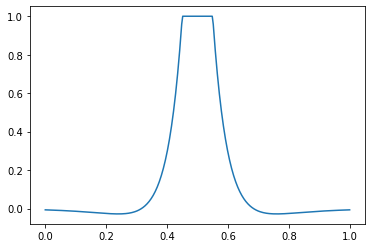

In [26]:
from top_hat import TopHat
TopHat().show_tophat()

In [27]:
%%writefile util.py
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Util:
  @staticmethod
  def add_gaussian_noise(tensor, mean=0., std=1.):
    t = tensor + torch.randn(tensor.size()).to(device) * std + mean
    t.to(device)
    return t

  @staticmethod
  def norm_scale(t):
    # print("mean", t.mean())
    # print("std", t.std())
    t = (t - t.mean()) / max(t.std(), 0.00001)
    # print("max", t.max())
    # print("min", t.min())
    t = t / max(t.max() - t.min(), 0.00001)
    t = t - t.min()
    # print("max", t.max())
    # print("min", t.min())

    return t

  @staticmethod
  def convolve(image_width, image_height, kernel_width, kernel_height, stride):
    convolutions = []
    for x in range(0, image_width - kernel_width + 1, stride):
      for y in range(0, image_height - kernel_height + 1, stride):
        convolutions.append([y, x, y + kernel_height, x + kernel_width])

    return convolutions

  @staticmethod
  def conv_slice(images, kernel_width, kernel_height, stride):
    image_count, image_height, image_width = images.shape
    convolutions = Util.convolve(image_width, image_height, kernel_width, kernel_height, stride)
    print("convolutions", len(convolutions))
    slices = [images[i, c[0]:c[2], c[1]:c[3]] for i in range(image_count) for c in convolutions]

    slices = [Util.norm_scale(slice) for slice in slices]
    
    slices = torch.stack(slices).float()
    slices = slices.view(slices.shape[0], -1).to(device)
    return slices

Overwriting util.py


In [38]:
%%writefile graphics_util.py
import matplotlib.pyplot as plt
import numpy as np

class GraphicsUtil:
  @staticmethod
  def show_image_grid(images, vmin=0, vmax=1, w=None, h=None):
    s = images.shape

    assert len(s) == 3
    if w is None or h is None:
      image_grid_size = int(s[0] ** 0.5)
      if image_grid_size > 10:
        return
      w = image_grid_size
      h = image_grid_size
    else:
      assert w * h == s[0]

    if w == 1 and h == 1:
      plt.figure(figsize=(h, w))
      plt.axis("off")
      plt.imshow(images[0].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.viridis, aspect='auto')
    else:
      fig, axs = plt.subplots(nrows=h, ncols=w, figsize=(w, h),
                            subplot_kw={'xticks': [], 'yticks': []})

      
      axs = axs.flat
      for i in np.arange(s[0]):
        axs[i].axis("off")
        axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.viridis, aspect='auto')
        
      fig.subplots_adjust(top=1, left=0, bottom=0, right=1, wspace=0.1, hspace=0.1)

    plt.show()


Overwriting graphics_util.py


In [50]:
%%writefile dataset_loader.py
from util import Util
from graphics_util import GraphicsUtil

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_cifar10(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_imagefolder(batch_size=64):
  loader = torch.utils.data.DataLoader(
      datasets.ImageFolder('/content/drive/My Drive/work/datasets/pattern',
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)
  
  return loader

def load_dataset(hp):
  images = next(iter(load_imagefolder(batch_size=1)))[0]
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  images = images[:,0,:,:].unsqueeze(1)
  ib, ic, ih, iw = images.shape
  print("images", images.shape)
  images = images.view(ib*ic, ih, iw)
  print("images", images.shape)

  plt.imshow(images[0], vmin=0, vmax=1)
  plt.show()

  plt.imshow(Util.norm_scale(images[0]), vmin=0, vmax=1)
  plt.show()
  original_dataset = Util.conv_slice(images, kernel_width=hp.image_width, kernel_height=hp.image_height, stride=hp.slice_stride)
  offset = 0
  original_dataset = original_dataset[offset:offset+hp.image_count]
  dataset = original_dataset
  GraphicsUtil.show_image_grid(dataset.view(-1, hp.image_height, hp.image_width))

  # for i in range(100, 120):
  #   print("Patch", i)
  #   x = dataset[i]
  #   show_image_grid(x.view(hp.image_height, hp.image_width).unsqueeze(0))
  #   plt.show()
  print(dataset.shape)
  return dataset

Overwriting dataset_loader.py


In [74]:
%%writefile pattern_memory_layer.py
from util import Util
from graphics_util import GraphicsUtil
from tophat import Tophat

import matplotlib.pyplot as plt
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class PatternMemoryLayer(torch.nn.Module):
  def __init__(self, hp):
    super().__init__()
    self.hp = hp
    self.tophat = Tophat(hp)

    self.patterns = torch.rand((self.hp.pattern_count, self.hp.pattern_size)).to(device) * self.hp.init_pattern_scale
    # self.patterns = torch.ones((self.hp.pattern_count, self.hp.pattern_size)).to(device)
    self.pattern_lr = torch.ones((self.patterns.shape[0],)).to(device) * 1.0
    self.pattern_var = torch.ones_like(self.patterns).to(device) * self.hp.init_pattern_var

    self.original_patterns = self.patterns.clone().to(device)
    GraphicsUtil.show_image_grid(self.patterns.view(-1, self.hp.image_height, self.hp.image_width))

  def forward(self, dataset):
    self.patterns, self.pattern_lr, self.pattern_var = run_dataset(dataset, self.patterns, self.pattern_lr, self.pattern_var, self.hp)

  def precision_weighted_distance(self, x, x_precision):
    mask = torch.exp(-self.pattern_var * self.hp.mask_contrast) # *3 so that var of 1 gives low enough mask value ~0.5. Thus mask range [0.5,1]
    dist_i = (x - self.patterns).abs()
    # print("dist_i", dist_i.shape)
    # print("pattern_lr", pattern_lr.shape)
    dist_i = dist_i * torch.exp(-self.pattern_lr*0.3).unsqueeze(-1) # mature patterns want to be winners for very specific patterns.
    di = (dist_i ** 2) * mask  # distance weighted by importance
    if x_precision is not None:
      di = di * x_precision
    dist = di.sum(dim=-1) / mask.sum(dim=-1) # dividing by mask sum ~= count of # of dims the pattern cares about
    return dist, dist_i

  def similarity(self, x, x_precision):
    # Formula derivation https://www.desmos.com/calculator/iokn9kyuaq
    # print("x", x)
    # print("patterns", patterns)
    dist, dist_i = self.precision_weighted_distance(x, x_precision)
    # print("dist", dist)
    winner_index = dist.min(dim=0)[1]
    # print("winner_index", winner_index)

    winning_pattern = self.patterns[winner_index]
    # print("winning_pattern", winning_pattern)

    sim = self.tophat(x, self.patterns, winning_pattern)

    # print("sim", sim)

    return sim, winner_index, dist, dist_i

  def autoassociative_recall(self, x, x_precision):
    dist, _ = self.precision_weighted_distance(x, x_precision)
    sim = torch.exp(-dist*100) * (1.0 - self.pattern_lr) # torch.exp(-pattern_lr*1)
    mask = torch.exp(-self.pattern_var * self.hp.mask_contrast)
    y = ((sim.unsqueeze(-1) * self.patterns * mask) / sim.sum(-1)).sum(dim=0)
    # y = ((y - 0.5) * 1.1) + 0.5
    return y

  def predict(self, dataset, dataset_precision):
    loss = 0.0
    output = []
    # pdb.set_trace()

    for i in range(dataset.shape[0]):
      x = dataset[i]
      if dataset_precision is not None:
        x_precision = dataset_precision[i]
      else:
        x_precision = None
      y = self.autoassociative_recall(x, x_precision)
      output.append(y)
      loss += torch.dist(x, y)

    output = torch.stack(output)
    # plot_patterns(output, pattern_lr=None, dataset=original_dataset, voronoi=False, annotate=False, figsize=(12,12))
    print("loss", loss)
    return output, loss

  def run_dataset(self, dataset):
    # print("pattern_var", pattern_var)
    winner_indices = []
    for x in dataset:
      sim, winner_index, dist, dist_i = self.similarity(x=x, x_precision=None)
      winner_indices.append(winner_index)
      sim = sim.unsqueeze(-1)

      self.pattern_lr[winner_index] = 0.9 * self.pattern_lr[winner_index] + 0.1 * (1.0 - torch.exp(-dist[winner_index]))
      self.pattern_var[winner_index] = 0.9 * self.pattern_var[winner_index] + 0.1 * dist_i[winner_index]

      delta = (x - self.patterns) * sim * self.hp.lr * self.pattern_lr.unsqueeze(-1)
      self.patterns = self.patterns + delta

    print("WINNERS: ", torch.bincount(torch.tensor(winner_indices)))
    self.patterns.clamp_(0, 1)
    self.pattern_lr.clamp(0, 1)


Overwriting pattern_memory_layer.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


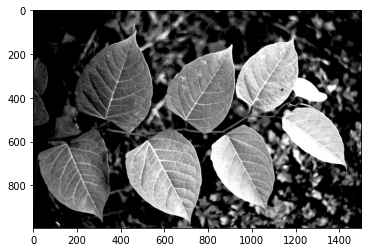

images torch.Size([1, 1, 994, 1500])
images torch.Size([1, 994, 1500])


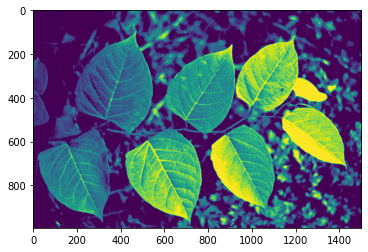

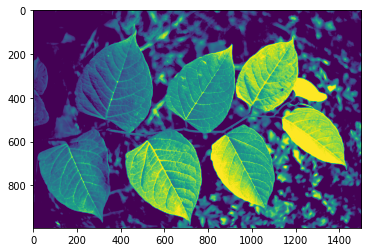

convolutions 163513
torch.Size([40000, 100])


In [52]:
%load_ext autoreload
%autoreload 1
%aimport hp
%aimport top_hat
%aimport util
%aimport graphics_util
%aimport dataset_loader
%aimport pattern_memory_layer

from hp import HP
from dataset_loader import load_dataset

original_dataset = dataset_loader.load_dataset(HP)


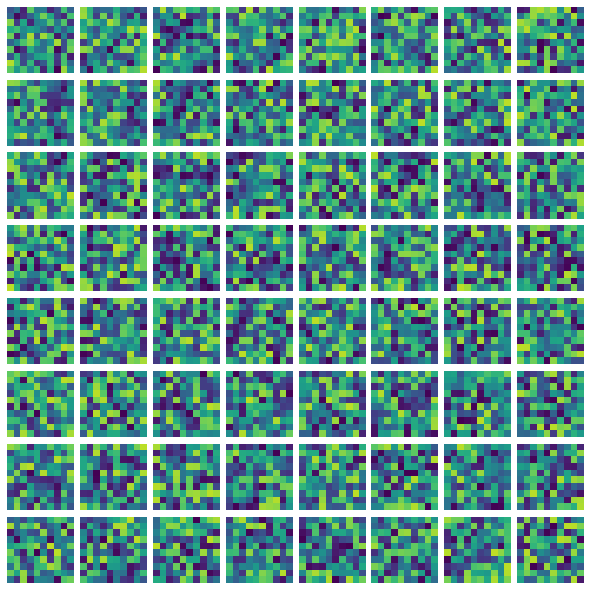

loss tensor(nan)
WINNERS:  tensor([  700,   492,   573,   717,   235,   660,   426,     0,   572,   434,
          521,   408,     0,   744,   533,   373,   471,   200,   270,   448,
            0,   524,   775,   242,   389,     0,   314,   645,  1325,   716,
         2937,   291,     0,   258,   354,   800,   493,   629,     0,   882,
          506,   317,   362,   557, 10839,  1202,   441,     4,   413,     5,
            0,   400,    11,   528,   482,    39,   483,   666,   266,   439,
          539,   736,   414])
loss tensor(69414.9609)


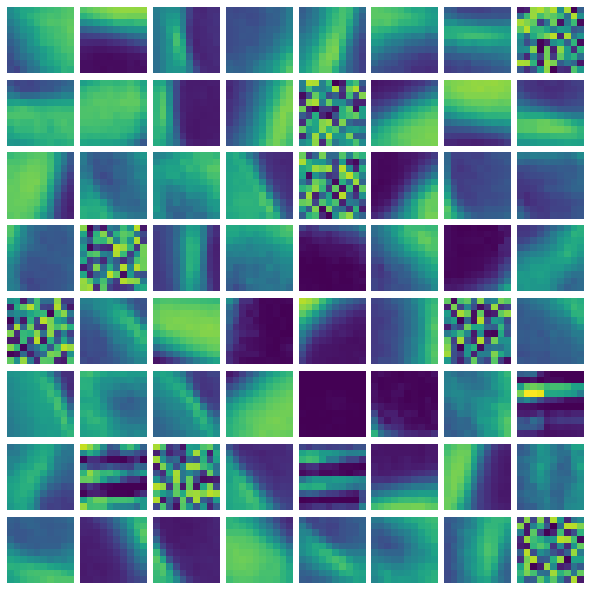

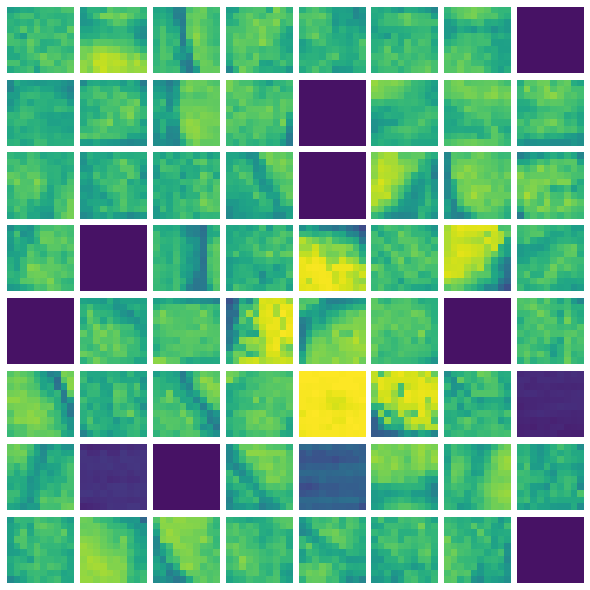

WINNERS:  tensor([  580,   376,   371,   673,   309,   566,   381,     0,   505,   378,
          394,   408,   427,   295,   325,   392,   427,   536,   462,   407,
           11,   453,   482,   385,   508,     0,   326,   661,  1203,   616,
         1721,   443,     0,   476,   401,  1151,   322,   760,     0,   782,
          515,   514,   353,   440, 10907,  1190,   373,   386,   329,   361,
            4,   479,   160,   395,   417,   498,   587,   572,   487,   446,
          440,   574,   340,   320])
loss tensor(69052.5312)


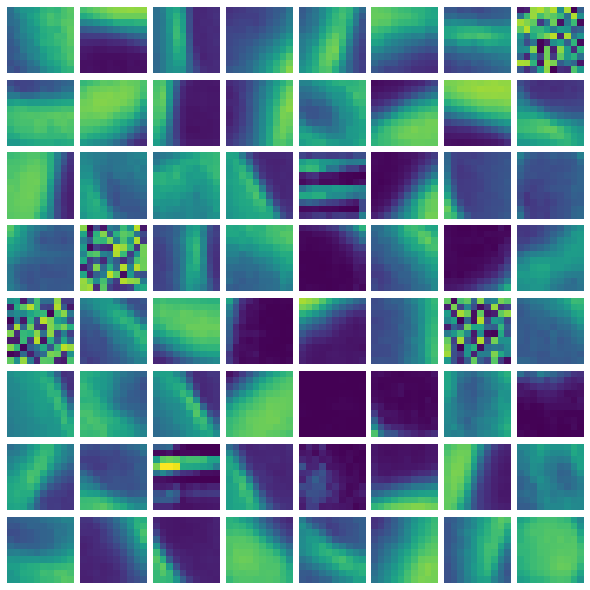

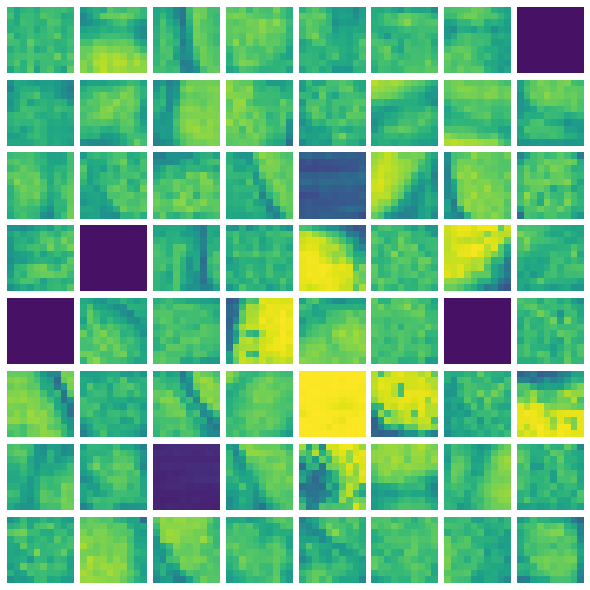

WINNERS:  tensor([  741,   309,   319,   589,   286,   426,   344,   263,   426,   358,
          374,   410,   459,   284,   295,   381,   336,   493,   444,   388,
           20,   438,   470,   420,   473,   440,   318,   605,  1009,   616,
         1519,   381,     0,   499,   443,   901,   250,   773,   172,   663,
          446,   498,   334,   376, 10887,  1060,   367,   776,   316,   469,
          187,   450,   613,   407,   372,   492,   604,   556,   425,   428,
          421,   505,   328,   348])
loss tensor(68568.4609)


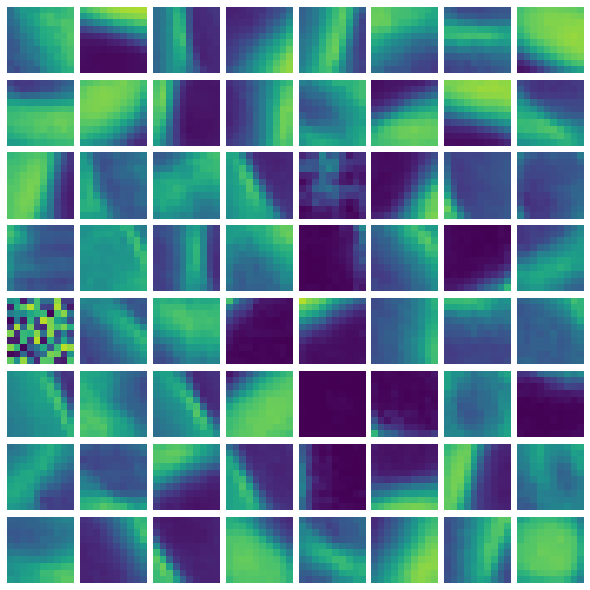

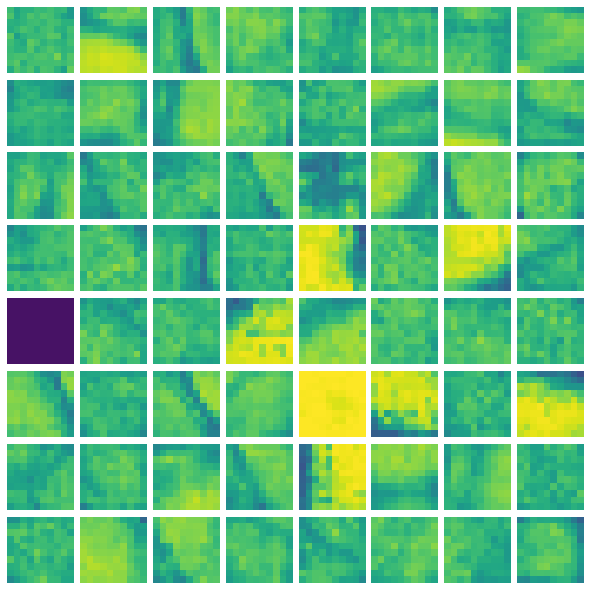

WINNERS:  tensor([  658,   293,   320,   446,   298,   457,   301,   262,   402,   372,
          345,   374,   476,   262,   288,   428,   380,   502,   394,   391,
          201,   433,   496,   482,   468,   465,   290,   688,   944,   528,
         1265,   410,     0,   495,   524,   780,   267,   784,   515,   680,
          401,   464,   330,   340, 10878,  1049,   364,   929,   310,   508,
          234,   438,   781,   388,   371,   411,   597,   495,   395,   430,
          412,   454,   332,   325])
loss tensor(68408.4219)


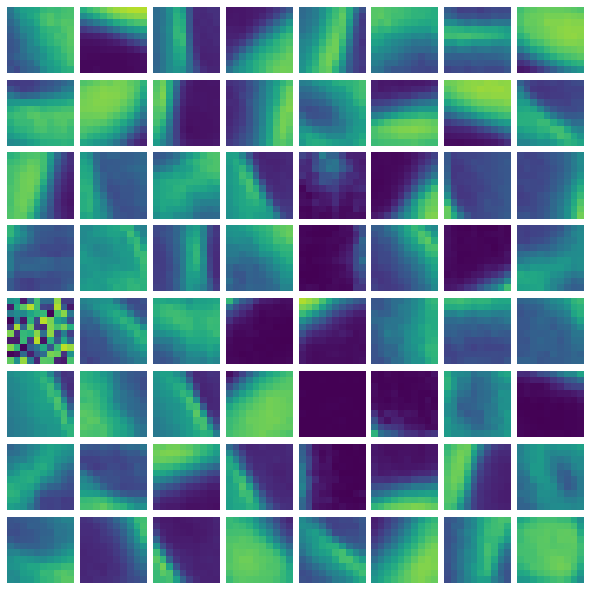

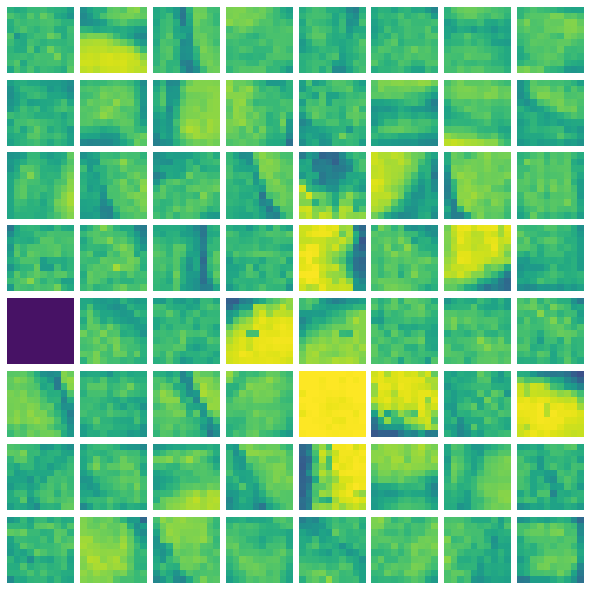

WINNERS:  tensor([  551,   286,   323,   335,   256,   485,   301,   277,   401,   368,
          339,   372,   479,   291,   262,   406,   376,   484,   383,   381,
          280,   414,   470,   668,   448,   438,   286,   806,   980,   540,
         1156,   451,    32,   501,   499,   741,   283,   763,   619,   640,
          417,   453,   301,   330, 10877,  1018,   365,   982,   348,   451,
          233,   419,   762,   391,   369,   406,   654,   492,   382,   430,
          402,   468,   337,   342])
loss tensor(68514.9297)


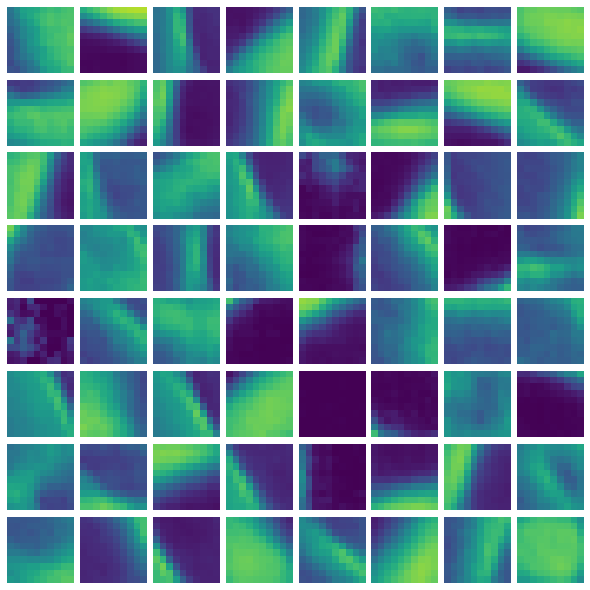

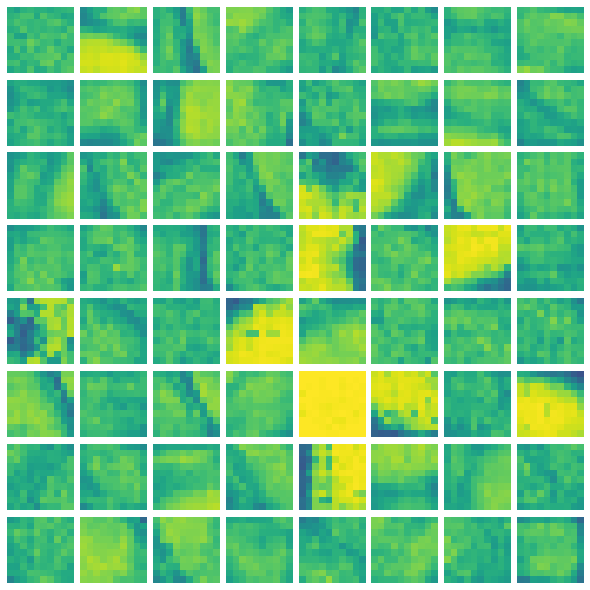

In [76]:
from hp import HP
from pattern_memory_layer import PatternMemoryLayer
from util import Util

HP.pattern_count = 8*8
layer1 = PatternMemoryLayer(HP)

def run(epochs=5, noise=0.0):
  dataset_precision = None

  layer1.predict(original_dataset, dataset_precision)
  for i in range(epochs):
    dataset = Util.add_gaussian_noise(original_dataset, std=noise)

    layer1.run_dataset(dataset)
    layer1.predict(original_dataset, dataset_precision)

    if (i+1) % int(epochs / 5) == 0:
      GraphicsUtil.show_image_grid(layer1.patterns.view(-1, HP.image_height, HP.image_width))
      GraphicsUtil.show_image_grid(torch.exp(-layer1.pattern_var.view(-1, HP.image_height, HP.image_width) * HP.mask_contrast))
      GraphicsUtil.show_image_grid(dataset.view(-1, HP.image_height, HP.image_width))

run()

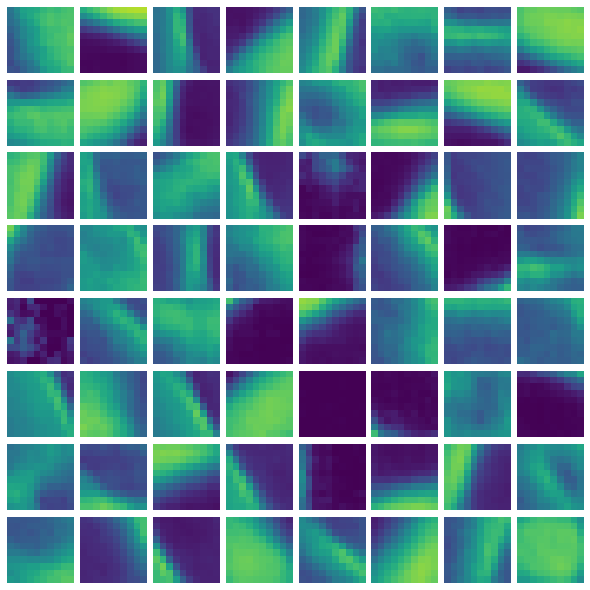

patch, prediction, winning pattern


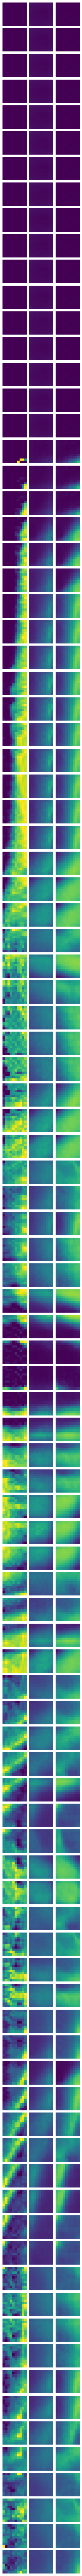

In [78]:
GraphicsUtil.show_image_grid(layer1.patterns.view(-1, HP.image_height, HP.image_width))

# for i in range(100, 120):
#   print("Patch", i)
#   x = dataset[i]
#   show_image_grid(x.view(HP.image_height, HP.image_width).unsqueeze(0))
#   plt.show()

result_images = []
for i in range(11000, 11100):
  # print("Patch", i)
  result_images_row = []

  x = dataset[i]
              
  result = layer1.autoassociative_recall(x, None)

  result_images_row.append(x.view(HP.image_height, HP.image_width))
  result_images_row.append(result.view(HP.image_height, HP.image_width))

  sim, winner_index, dist, dist_i = layer1.similarity(x=x, x_precision=None)
  winning_pattern = layer1.patterns[winner_index]
  result_images_row.append(winning_pattern.view(HP.image_height, HP.image_width))

  result_images.append(torch.stack(result_images_row))

print("patch, prediction, winning pattern")
result_images = torch.stack(result_images)
h, w, ih, iw = result_images.shape
GraphicsUtil.show_image_grid(result_images.view(-1, ih, iw), h=h, w=w)
